In [89]:
import pandas as pd
import matplotlib.pyplot as plt

Login record

In [255]:
login_record = pd.read_csv('createrole_login_record.csv')
session_data = pd.read_csv('user_daily_session_length_record.csv')
payment_record = pd.read_csv('user_payment_record.csv')

In [256]:
login_record = login_record[(login_record['server_id'] != 0) & (login_record['server_id'] != -30000)]

In [257]:
payment_record = payment_record[(payment_record['server_id'] != 0) & (payment_record['server_id'] != -30000)]

In [223]:
# one month login record
login_record['dt'].min()

'2024-10-18'

In [6]:
login_record['dt'].max()

'2024-11-18'

In [8]:
login_record['appid'].nunique()

1

In [10]:
login_record['ctwid'].nunique()

500286

In [11]:
login_record.shape

(3832735, 6)

In [13]:
login_record['type'].value_counts()

type
g_login         3385556
g_createrole     447179
Name: count, dtype: int64

In [15]:
# 80 server
login_record['server_id'].nunique()

80

In [21]:
# multiple server for one user, that means multiple games for one user or multiple account same user for one game?
login_record.groupby('ctwid')['server_id'].nunique().reset_index().sort_values('server_id', ascending=False).head(5)

,ctwid,server_id
149784,4cab45594d,41
225670,7367531b9b,40
304338,9b6cf5880f,39
292774,958c38318c,38
2518,015b299eda,34


In [271]:
login_record.groupby('server_id')['ctwid'].nunique()

server_id
1     7369
2     6103
3     9397
4     6200
5     8992
      ... 
74    5762
75    5753
76    5726
77    5822
78    2689
Name: ctwid, Length: 78, dtype: int64

Session data

In [51]:
# one month login record
session_data['dt'].min()

'2024-10-18'

In [52]:
session_data['dt'].max()

'2024-11-18'

In [53]:
session_data['session_length'].describe()

count    2.755444e+06
mean     1.329310e+03
std      5.706346e+03
min      1.000000e+00
25%      1.000000e+00
50%      5.000000e+00
75%      8.800000e+01
max      9.194100e+04
Name: session_length, dtype: float64

In [233]:
session_data['session_length_minutes'] = session_data['session_length'] / 60

In [56]:
session_data['session_length_minutes'].describe()

count    2.755444e+06
mean     2.215517e+01
std      9.510576e+01
min      1.666667e-02
25%      1.666667e-02
50%      8.333333e-02
75%      1.466667e+00
max      1.532350e+03
Name: session_length_minutes, dtype: float64

In [31]:
session_data['ctwid'].nunique()

2162632

In [32]:
session_data.shape

(2755444, 4)

Payment record

In [41]:
payment_record[payment_record['pay_amt'] > 0]['pay_amt'].describe()

count    106280.000000
mean        922.281511
std        2342.792591
min           1.000000
25%         100.000000
50%         100.000000
75%        1080.000000
max       99700.000000
Name: pay_amt, dtype: float64

<Axes: >

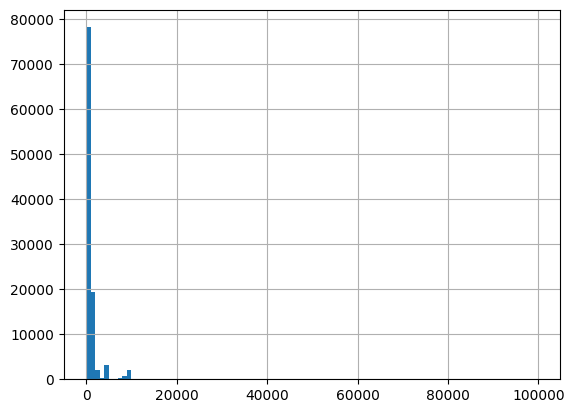

In [40]:
payment_record[payment_record['pay_amt'] > 0]['pay_amt'].hist(bins=100)

In [43]:
payment_record['server_id'].nunique()

78

# 1st round questions
1. ctwid 我理解是用户的唯一ID，但我看见有单用户对多服务器的情况。这个是说同个用户能在多个服务登录么，还是说这里的数据是多个游戏的？
2. session data 里的session_length 单位对应是秒对吧？

没有得到确切回答，先做假设：
1. appid应该是游戏ID，假设是同个用户能在多个服务器登录（可能是登录页面可选择服务器）
2. 基于数据的分布，假设session_length 的单位是秒

每个服务器目前的开服时间

In [70]:
from datetime import datetime

def calculate_days_difference(date1: str, date2: str) -> int:
    """
    Calculate the difference in days between two dates in the format 'YYYY-MM-DD'.

    :param date1: The first date as a string.
    :param date2: The second date as a string.
    :return: The absolute difference in days as an integer.
    """
    # Convert the date strings to datetime objects
    date_format = "%Y-%m-%d"
    d1 = datetime.strptime(date1, date_format)
    d2 = datetime.strptime(date2, date_format)
    
    # Calculate the difference in days
    difference = abs((d2 - d1).days)
    return difference

In [63]:
server_start_data = login_record.groupby('server_id')['dt'].min().reset_index()

In [67]:
server_start_data['end_date'] = "2024-11-18"

In [71]:
server_start_data['server_duration'] = server_start_data[['end_date', 'dt']].apply(lambda x: calculate_days_difference(x[0], x[1]), axis=1)

/var/folders/63/qfnv50d13555lrfq69p51_700000gn/T/ipykernel_68370/2001837042.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  server_start_data['server_duration'] = server_start_data[['end_date', 'dt']].apply(lambda x: calculate_days_difference(x[0], x[1]), axis=1)


In [74]:
# 目前数据的开服时间，前20天较为保守差不多一天一服，后10天比较激进，差不多一天开5～6服
server_start_data.groupby('server_duration')['server_id'].nunique().sort_index()

server_duration
0     7
1     8
2     7
3     7
4     6
5     5
6     5
7     4
8     6
9     6
10    3
11    1
13    1
15    1
17    1
19    1
20    1
21    1
22    1
23    1
24    1
25    2
26    3
31    1
Name: server_id, dtype: int64

DAU trend

In [240]:
session_server_data = session_data.merge(login_record[['dt', 'ctwid', 'server_id']].drop_duplicates(), 'inner', ['dt', 'ctwid'])

In [248]:
dau = session_server_data.groupby('dt')['ctwid'].nunique().reset_index().rename(columns={'ctwid': 'dau', 'dt': 'date'})

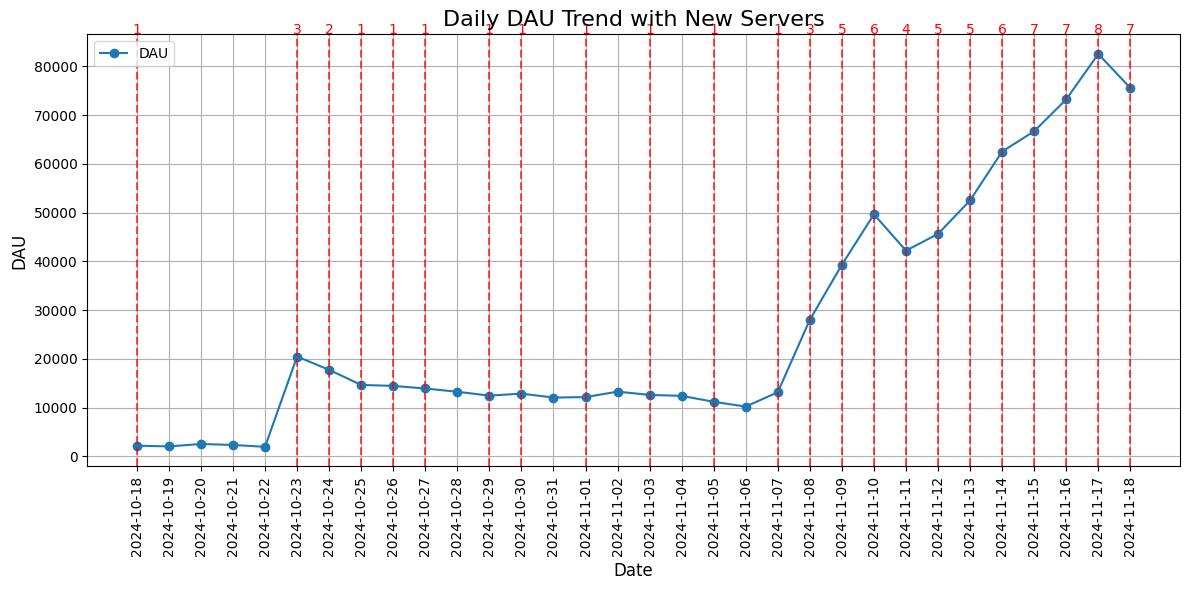

In [250]:
import pandas as pd
import matplotlib.pyplot as plt

# 确保日期列转换为 datetime 格式
payment_record['date'] = pd.to_datetime(payment_record['date'])
login_record['dt'] = pd.to_datetime(login_record['dt'])

# 计算每天上线的新服务器数量
new_servers_per_day = login_record.groupby('server_id')['dt'].min().reset_index()
new_servers_per_day = new_servers_per_day.groupby('dt')['server_id'].nunique().reset_index()
new_servers_per_day.rename(columns={'dt': 'date', 'server_id': 'new_servers'}, inplace=True)

# 确保日期格式一致
dau['date'] = pd.to_datetime(dau['date'])
new_servers_per_day['date'] = pd.to_datetime(new_servers_per_day['date'])

# 绘制每日 ARPPU 变化趋势
plt.figure(figsize=(12, 6))
plt.plot(dau['date'], dau['dau'], marker='o', label='DAU')

# 添加竖直红线标记新服务器上线
for _, row in new_servers_per_day.iterrows():
    date = row['date']
    new_servers = row['new_servers']
    plt.axvline(date, color='red', linestyle='--', alpha=0.7)
    plt.text(date, max(dau['dau']) * 1.05, f"{new_servers}",
             color='red', fontsize=10, ha='center')

# 设置 x 轴标签竖直显示
plt.xticks(dau['date'], rotation=90)

# 添加标题和轴标签
plt.title("Daily DAU Trend with New Servers", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("DAU", fontsize=12)
plt.grid(True)

# 添加图例
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()

GMV trend

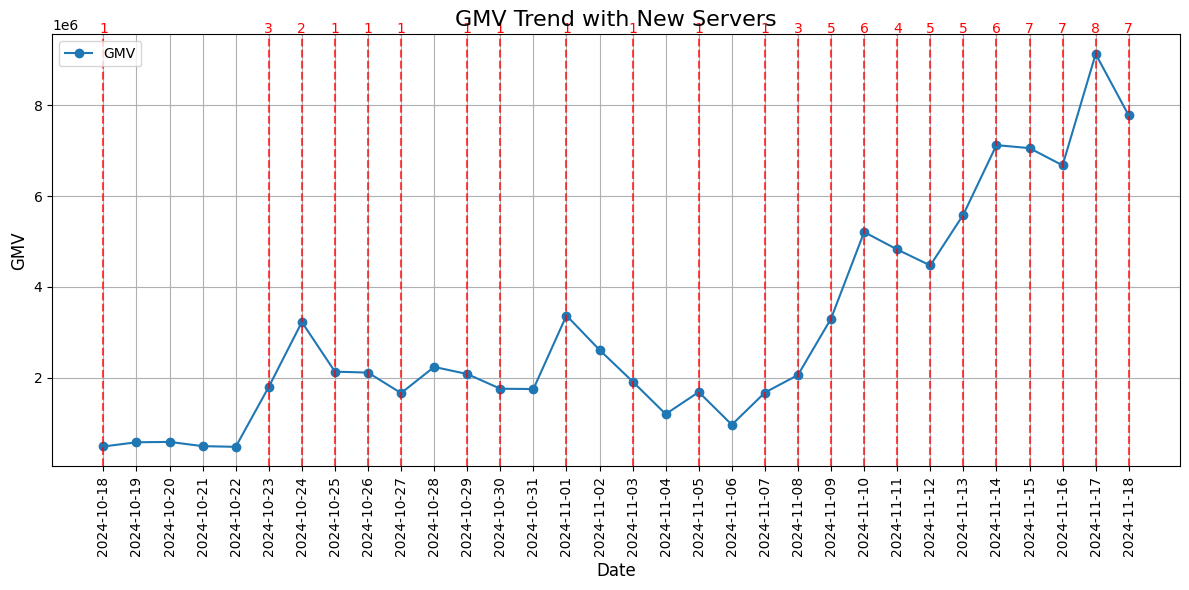

In [278]:
import pandas as pd
import matplotlib.pyplot as plt

# 确保日期列转换为 datetime 格式
payment_record['date'] = pd.to_datetime(payment_record['date'])
login_record['dt'] = pd.to_datetime(login_record['dt'])

# 计算每日 ARPPU
payment_trend = payment_record.groupby('date')['pay_amt'].sum().reset_index()


# 计算每天上线的新服务器数量
new_servers_per_day = login_record.groupby('server_id')['dt'].min().reset_index()
new_servers_per_day = new_servers_per_day.groupby('dt')['server_id'].nunique().reset_index()
new_servers_per_day.rename(columns={'dt': 'date', 'server_id': 'new_servers'}, inplace=True)

# 确保日期格式一致
payment_trend['date'] = pd.to_datetime(payment_trend['date'])
new_servers_per_day['date'] = pd.to_datetime(new_servers_per_day['date'])

# 绘制每日 ARPPU 变化趋势
plt.figure(figsize=(12, 6))
plt.plot(payment_trend['date'], payment_trend['pay_amt'], marker='o', label='GMV')

# 添加竖直红线标记新服务器上线
for _, row in new_servers_per_day.iterrows():
    date = row['date']
    new_servers = row['new_servers']
    plt.axvline(date, color='red', linestyle='--', alpha=0.7)
    plt.text(date, max(payment_trend['pay_amt']) * 1.05, f"{new_servers}",
             color='red', fontsize=10, ha='center')

# 设置 x 轴标签竖直显示
plt.xticks(payment_trend['date'], rotation=90)

# 添加标题和轴标签
plt.title("GMV Trend with New Servers", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("GMV", fontsize=12)
plt.grid(True)

# 添加图例
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()

ARPPU trend

In [85]:
arppu = payment_record.groupby(['server_id', 'date']).agg({'ctwid': 'nunique', 'pay_amt': 'sum'}).reset_index()

In [87]:
arppu['arppu'] = arppu['pay_amt'] / arppu['ctwid']

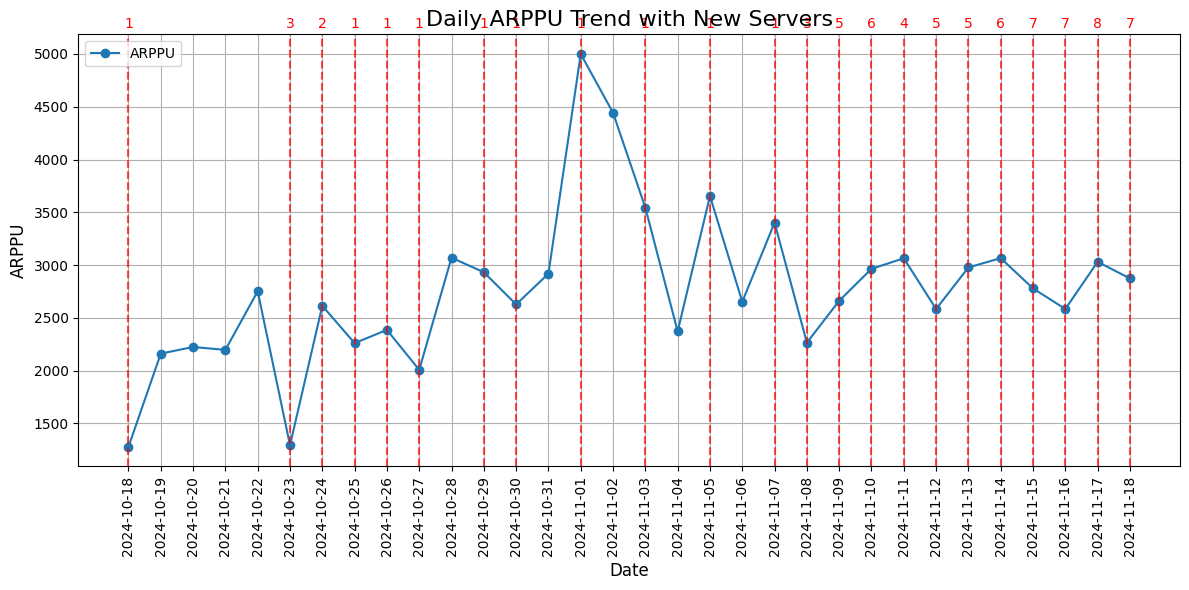

In [226]:
import pandas as pd
import matplotlib.pyplot as plt

# 确保日期列转换为 datetime 格式
payment_record['date'] = pd.to_datetime(payment_record['date'])
login_record['dt'] = pd.to_datetime(login_record['dt'])

# 计算每日 ARPPU
arppu = payment_record.groupby(['server_id', 'date']).agg({'ctwid': 'nunique', 'pay_amt': 'sum'}).reset_index()
arppu['arppu'] = arppu['pay_amt'] / arppu['ctwid']

agg_arppu = payment_record.groupby(['date']).agg({'ctwid': 'nunique', 'pay_amt': 'sum'}).reset_index()
agg_arppu['arppu'] = agg_arppu['pay_amt'] / agg_arppu['ctwid']

# 计算每天上线的新服务器数量
new_servers_per_day = login_record.groupby('server_id')['dt'].min().reset_index()
new_servers_per_day = new_servers_per_day.groupby('dt')['server_id'].nunique().reset_index()
new_servers_per_day.rename(columns={'dt': 'date', 'server_id': 'new_servers'}, inplace=True)

# 确保日期格式一致
agg_arppu['date'] = pd.to_datetime(agg_arppu['date'])
new_servers_per_day['date'] = pd.to_datetime(new_servers_per_day['date'])

# 绘制每日 ARPPU 变化趋势
plt.figure(figsize=(12, 6))
plt.plot(agg_arppu['date'], agg_arppu['arppu'], marker='o', label='ARPPU')

# 添加竖直红线标记新服务器上线
for _, row in new_servers_per_day.iterrows():
    date = row['date']
    new_servers = row['new_servers']
    plt.axvline(date, color='red', linestyle='--', alpha=0.7)
    plt.text(date, max(agg_arppu['arppu']) * 1.05, f"{new_servers}",
             color='red', fontsize=10, ha='center')

# 设置 x 轴标签竖直显示
plt.xticks(agg_arppu['date'], rotation=90)

# 添加标题和轴标签
plt.title("Daily ARPPU Trend with New Servers", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("ARPPU", fontsize=12)
plt.grid(True)

# 添加图例
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()

survival trend

In [264]:
# 确保 dt 列是日期格式
login_record['dt'] = pd.to_datetime(login_record['dt'])

# 计算次日留存率
def calculate_next_day_retention(login_record):
    # 按日期分组，获取每天的用户集合
    daily_users = login_record.groupby('dt')['ctwid'].apply(set).reset_index(name='users')
    
    # 创建一个 DataFrame 存储次日留存率
    retention_rates = []
    
    for i in range(len(daily_users) - 1):
        current_day = daily_users.iloc[i]
        next_day = daily_users.iloc[i + 1]
        
        # 当前日期和次日日期
        current_date = current_day['dt']
        next_date = next_day['dt']
        
        # 当前日期的用户集合和次日的用户集合
        current_users = current_day['users']
        next_users = next_day['users']
        
        # 计算次日留存用户数
        retained_users = current_users.intersection(next_users)
        
        # 计算次日留存率
        retention_rate = len(retained_users) / len(current_users) if len(current_users) > 0 else 0
        
        # 保存结果
        retention_rates.append({
            'date': current_date,
            'next_day_date': next_date,
            'retention_rate': retention_rate
        })
    
    return pd.DataFrame(retention_rates)

# 计算次日留存率
retention_df = calculate_next_day_retention(login_record)

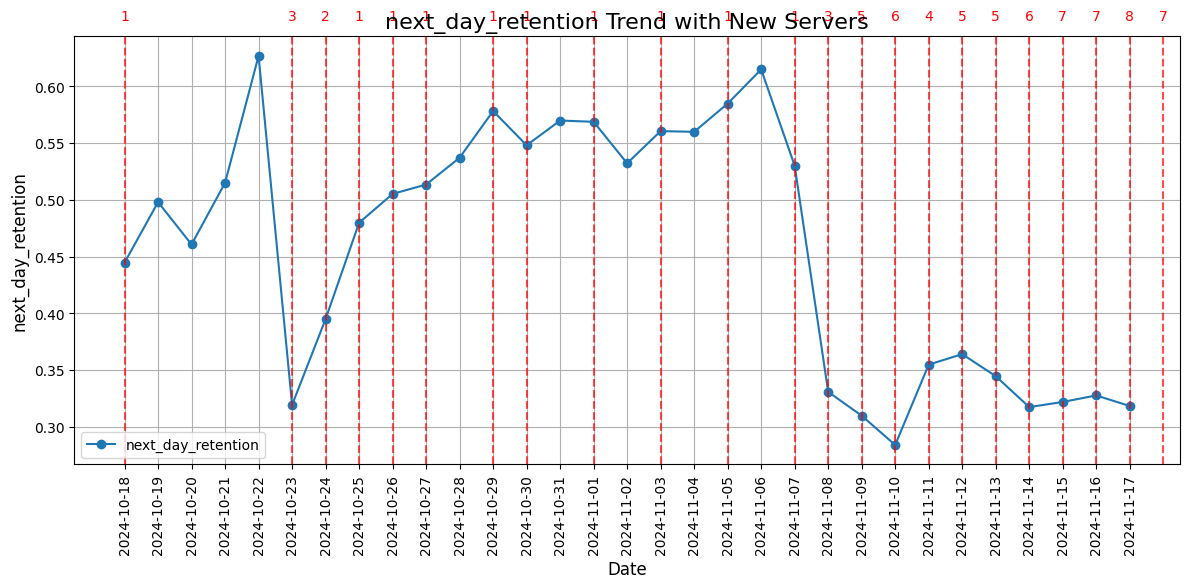

In [268]:
import pandas as pd
import matplotlib.pyplot as plt

# 确保日期列转换为 datetime 格式
payment_record['date'] = pd.to_datetime(payment_record['date'])
login_record['dt'] = pd.to_datetime(login_record['dt'])

# 计算每天上线的新服务器数量
new_servers_per_day = login_record.groupby('server_id')['dt'].min().reset_index()
new_servers_per_day = new_servers_per_day.groupby('dt')['server_id'].nunique().reset_index()
new_servers_per_day.rename(columns={'dt': 'date', 'server_id': 'new_servers'}, inplace=True)

# 确保日期格式一致
retention_df['date'] = pd.to_datetime(retention_df['date'])
new_servers_per_day['date'] = pd.to_datetime(new_servers_per_day['date'])

# 绘制每日 ARPPU 变化趋势
plt.figure(figsize=(12, 6))
plt.plot(retention_df['date'], retention_df['retention_rate'], marker='o', label='next_day_retention')

# 添加竖直红线标记新服务器上线
for _, row in new_servers_per_day.iterrows():
    date = row['date']
    new_servers = row['new_servers']
    plt.axvline(date, color='red', linestyle='--', alpha=0.7)
    plt.text(date, max(retention_df['retention_rate']) * 1.05, f"{new_servers}",
             color='red', fontsize=10, ha='center')

# 设置 x 轴标签竖直显示
plt.xticks(retention_df['date'], rotation=90)

# 添加标题和轴标签
plt.title("next_day_retention Trend with New Servers", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("next_day_retention", fontsize=12)
plt.grid(True)

# 添加图例
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()

Active User vs ARPPU

In [186]:
session_server_data = session_data[session_data['session_length_minutes'] > 0].merge(login_record[['dt', 'ctwid', 'server_id']].drop_duplicates(), 'inner', ['dt', 'ctwid'])

In [168]:
# dau_data = session_server_data[session_server_data['server_id'] == 5].groupby('dt')['ctwid'].nunique().reset_index().rename(columns={'ctwid': 'dau'})
# dau_by_arppu = dau_data.merge(arppu[arppu['server_id'] == 5], 'inner', left_on='dt', right_on='date')
# dau_by_arppu.sort_values(['dau', 'arppu'], ascending=True, inplace=True)
# dau_by_arppu.drop_duplicates('dau', inplace=True)

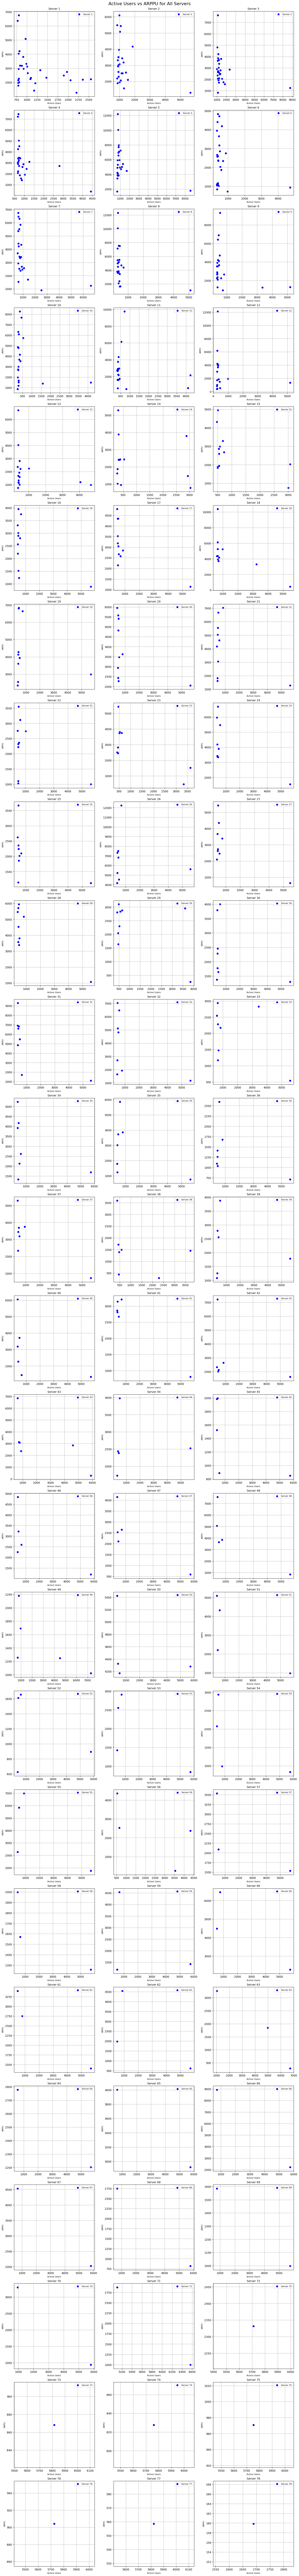

In [191]:
import numpy as np
import matplotlib.pyplot as plt

# 获取唯一的服务器 ID 列表
server_ids = sorted(session_server_data['server_id'].unique())

# 确定矩阵的行列数（比如 3 列，行数根据服务器数量自动调整）
n_cols = 3
n_rows = int(np.ceil(len(server_ids) / n_cols))

# 创建子图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()  # 将子图矩阵展平，方便迭代

# 遍历每个服务器 ID
for i, server_id in enumerate(server_ids):
    # 筛选当前服务器的数据
    dau_data = session_server_data[session_server_data['server_id'] == server_id].groupby('dt')['ctwid'].nunique().reset_index().rename(columns={'ctwid': 'dau'})
    dau_by_arppu = dau_data.merge(arppu[arppu['server_id'] == server_id], 'inner', left_on='dt', right_on='date')
    dau_by_arppu.sort_values(['dau', 'arppu'], ascending=True, inplace=True)
    dau_by_arppu.drop_duplicates('dau', inplace=True)
    
    # 获取活跃用户数和 ARPU 数据
    active_users = dau_by_arppu['dau'].tolist()
    arpu_values = dau_by_arppu['arppu'].tolist()
    
    # 在子图中绘制散点图
    ax = axes[i]
    ax.scatter(active_users, arpu_values, color='blue', label=f'Server {server_id}')
    ax.set_title(f'Server {server_id}', fontsize=10)
    ax.set_xlabel('Active Users', fontsize=8)
    ax.set_ylabel('ARPU', fontsize=8)
    ax.grid(True)
    ax.legend(fontsize=8)

# 删除多余的子图（如果服务器数量不足以填满矩阵）
for j in range(len(server_ids), len(axes)):
    fig.delaxes(axes[j])

# 显示图表
plt.suptitle('Active Users vs ARPPU for All Servers', fontsize=16)
plt.show()



In [269]:
login_record.groupby('server_id')['dt'].min().reset_index()

,server_id,dt
0,1,2024-10-18
1,2,2024-10-23
2,3,2024-10-23
3,4,2024-10-23
4,5,2024-10-24
...,...,...
73,74,2024-11-18
74,75,2024-11-18
75,76,2024-11-18
76,77,2024-11-18


In [280]:
print(login_record.head(10))

  appid         dt       ctwid  server_id     type           time
0  test 2024-11-17  84a787b8d4         44  g_login  1731843941000
1  test 2024-11-17  42fa4799c1         34  g_login  1731843977000
2  test 2024-11-17  96c22d3440         60  g_login  1731843979000
3  test 2024-11-17  def76d1d2b          9  g_login  1731843937000
4  test 2024-11-17  5ece9bf10e         18  g_login  1731843984000
5  test 2024-11-17  a7c8fc1bd0          1  g_login  1731843982000
6  test 2024-11-17  985b75586e         49  g_login  1731843969000
7  test 2024-11-17  434e4cc7bb         70  g_login  1731843959000
8  test 2024-11-17  efeb16f966         19  g_login  1731843967000
9  test 2024-11-17  401bb74839          7  g_login  1731843968000


In [279]:
print(payment_record.head(10))

  appid       date       ctwid  server_id           time  pay_amt
0  test 2024-11-13  23dccf736f          2  1731509951124      100
1  test 2024-11-13  2cac52ff60          3  1731509996850      100
2  test 2024-11-13  af687842ae         43  1731509995400      100
3  test 2024-11-14  44f3cee987         43  1731510028964        1
4  test 2024-11-14  01c6034980          9  1731510053112       79
5  test 2024-11-14  ce87baa5ea         32  1731510063090       79
6  test 2024-11-14  368a47d52d          8  1731510078838       79
7  test 2024-11-14  15a3c778d0         26  1731510105819      871
8  test 2024-11-14  8f7258120a         33  1731510112382       86
9  test 2024-11-14  368a47d52d          8  1731510084199       79


In [281]:
print(session_data.head(10))

  appid          dt       ctwid  session_length
0  test  2024-11-17  a512b8cf9b              17
1  test  2024-11-17  5601d6307c            1898
2  test  2024-11-17  a0e52a52cc            1894
3  test  2024-11-17  88321a495c               1
4  test  2024-11-17  0d649666d6            6185
5  test  2024-11-17  bd6edaf313           11660
6  test  2024-11-17  5283ff9def              23
7  test  2024-11-17  2f4e17fe1f               1
8  test  2024-11-17  ed2fa876be               2
9  test  2024-11-17  58d7fd879e               2
